In [1]:
import re
import regex
import pathlib
from functools import reduce
import csv
import itertools
import pandas as pd
import nltk
from nltk.util import ngrams, pad_sequence
from nltk.probability import FreqDist
from nltk.collocations import *
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk.corpus import stopwords, PlaintextCorpusReader
from nltk.tokenize import regexp_tokenize, sent_tokenize

from sklearn.model_selection import train_test_split

In [2]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mark.sherman/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/mark.sherman/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/mark.sherman/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/mark.sherman/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [3]:
df = pd.read_csv("../assets/cyberbullying_tweets.csv")
df.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [4]:
df["tweet_text"].apply(lambda n: len(n.split())).sum()

1130531

In [5]:
# Check null values
df.isna().any()

tweet_text            False
cyberbullying_type    False
dtype: bool

In [6]:
# Count duplicates
df.duplicated().sum()

36

In [7]:
df.drop_duplicates(keep='first', inplace=True)

In [8]:
df['cyberbullying_type'].value_counts()

cyberbullying_type
religion               7997
age                    7992
ethnicity              7959
gender                 7948
not_cyberbullying      7937
other_cyberbullying    7823
Name: count, dtype: int64

## Sentence tokenizer

In [9]:
simple_email_pattern = r"\S+@\S+\.\S+"
normal_email_pattern = r"[a-z0-9!#$%&'*+/=?^_`{|}~-]+(?:\.[a-z0-9!#$%&'*+/=?^_`{|}~-]+)*@(?:[a-z0-9](?:[a-z0-9-]*[a-z0-9])?\.)+[a-z0-9](?:[a-z0-9-]*[a-z0-9])?"

simple_phone_pattern = r"\\+?[1-9][0-9]{7,14}"
normal_phone_pattern = r"\+?\d{1,4}?[-.\s]?\(?\d{1,3}?\)?[-.\s]?\d{1,4}[-.\s]?\d{1,4}[-.\s]?\d{1,9}"

normal_url_pattern = r"(?:https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})"
normal_url_pattern_v2 = r"(?:https:\/\/www\.|http:\/\/www\.|https:\/\/|http:\/\/)?[a-zA-Z]{2,}(?:\.[a-zA-Z]{2,})(?:\.[a-zA-Z]{2,})?\/[a-zA-Z0-9]{2,}|(?:(?:https:\/\/www\.|http:\/\/www\.|https:\/\/|http:\/\/)?[a-zA-Z]{2,}(?:\.[a-zA-Z]{2,})(?:\.[a-zA-Z]{2,})?)|(?:https:\/\/www\.|http:\/\/www\.|https:\/\/|http:\/\/)?[a-zA-Z0-9]{2,}\.[a-zA-Z0-9]{2,}\.[a-zA-Z0-9]{2,}(\.[a-zA-Z0-9]{2,})?"
# https://ihateregex.io/expr/phone/
#normal_phone_pattern = r"[\+]?[(]?[0-9]{3}[)]?[-\s\.]?[0-9]{3}[-\s\.]?[0-9]{4,6}"

In [10]:
alphabets= "([A-Za-z])"
prefixes = "(Mr|St|Mrs|Ms|Dr)[.]"
suffixes = "(Inc|Ltd|Jr|Sr|Co)"
starters = "(Mr|Mrs|Ms|Dr|Prof|Capt|Cpt|Lt|He\s|She\s|It\s|They\s|Their\s|Our\s|We\s|But\s|However\s|That\s|This\s|Wherever)"
acronyms = "([A-Z][.][A-Z][.](?:[A-Z][.])?)"
websites = "[.](com|net|org|io|gov|edu|me)"
digits = "([0-9])"
multiple_dots = r'\.{2,}'
newlines = "\n+"

def split_into_sentences(text: str) -> list[str]:
    """
    Split the text into sentences.

    If the text contains substrings "<prd>" or "<stop>", they would lead 
    to incorrect splitting because they are used as markers for splitting.

    :param text: text to be split into sentences
    :type text: str

    :return: list of sentences
    :rtype: list[str]
    """
    text = " " + text + "  "
    text = re.sub("^\s+", " ", text)
    
    email_iter = re.finditer(normal_email_pattern, text)
    for m in email_iter:
        text = text.replace(m.group(), m.group().replace(".", "<prd>"))

    phone_iter = re.finditer(normal_phone_pattern, text)
    for m in phone_iter:
        text = text.replace(m.group(), m.group().replace(".", "<prd>"))

    url_iter = re.finditer(normal_url_pattern, text)
    for m in url_iter:
        text = text.replace(m.group(), m.group().replace(".", "<prd>"))

    text = re.sub(r"(\,|\:|\;)*((\?|\!|\.)+)(\,|\:|\;)*", "\\2", text)
    text = re.sub(r"(\.+)[\?\!\.]*", "\\1<stop>", text)
    text = re.sub(r"((\?|\!)+)[\?\!\.]*", "\\1<stop>", text)
    text = re.sub(r"((\?+\!)|(\!+\?))[\?\!\.]*", "?!<stop>", text)
        
    text = re.sub(prefixes,"\\1<prd>",text)
    text = re.sub(websites,"<prd>\\1",text)
    text = re.sub(digits + "[.]" + digits,"\\1<prd>\\2",text)
    text = re.sub(multiple_dots, lambda match: "<prd>" * len(match.group(0)) + "<stop>", text)

    text = re.sub(newlines, "<stop>", text)
    
    if "Ph.D" in text: text = text.replace("Ph.D.","Ph<prd>D<prd>")
    text = re.sub("\s" + alphabets + "[.] "," \\1<prd> ",text)
    text = re.sub(acronyms + " " + starters, "\\1<stop> \\2",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]" + alphabets + "[.]", "\\1<prd>\\2<prd>\\3<prd>",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]", "\\1<prd>\\2<prd>",text)
    text = re.sub(" " + suffixes + "[.] " + starters," \\1<stop> \\2",text)
    text = re.sub(" " + suffixes + "[.]"," \\1<prd>",text)
    text = re.sub(" " + alphabets + "[.]"," \\1<prd>",text)
    if "”" in text: text = text.replace(".”","”.")
    if "\"" in text: text = text.replace(".\"","\".")
    if "!" in text: text = text.replace("!\"","\"!")
    if "?" in text: text = text.replace("?\"","\"?")
    text = text.replace(".",".<stop>")
    text = text.replace("(?|!|?!)","\\1<stop>")

    text = text.replace("<prd>",".")
    
    text = re.sub("(\s*<stop>\s*){2,}", "<stop>", text)
    
    sentences = text.split("<stop>")
    sentences = [s.strip() for s in sentences]
    if sentences and not sentences[-1]: sentences = sentences[:-1]
    return sentences

In [11]:
def tokenize_sentences(text, method="custom") -> list[str]:
    if method == "nltk":
        return sent_tokenize(text)
    elif method == "custom":
        return split_into_sentences(text)

In [12]:
df["sentences"] = df["tweet_text"].apply(split_into_sentences)

In [13]:
df["sentences_count"] = df["sentences"].apply(len)
pd.set_option('display.max_colwidth', None)
df.head(10)

,tweet_text,cyberbullying_type,sentences,sentences_count
0,"In other words #katandandre, your food was crapilicious! #mkr",not_cyberbullying,"[In other words #katandandre, your food was crapilicious!, #mkr]",2
1,Why is #aussietv so white? #MKR #theblock #ImACelebrityAU #today #sunrise #studio10 #Neighbours #WonderlandTen #etc,not_cyberbullying,"[Why is #aussietv so white?, #MKR #theblock #ImACelebrityAU #today #sunrise #studio10 #Neighbours #WonderlandTen #etc]",2
2,@XochitlSuckkks a classy whore? Or more red velvet cupcakes?,not_cyberbullying,"[@XochitlSuckkks a classy whore?, Or more red velvet cupcakes?]",2
3,"@Jason_Gio meh. :P thanks for the heads up, but not too concerned about another angry dude on twitter.",not_cyberbullying,"[@Jason_Gio meh., :P thanks for the heads up, but not too concerned about another angry dude on twitter.]",2
4,"@RudhoeEnglish This is an ISIS account pretending to be a Kurdish account. Like Islam, it is all lies.",not_cyberbullying,"[@RudhoeEnglish This is an ISIS account pretending to be a Kurdish account., Like Islam, it is all lies.]",2
5,"@Raja5aab @Quickieleaks Yes, the test of god is that good or bad or indifferent or weird or whatever, it all proves gods existence.",not_cyberbullying,"[@Raja5aab @Quickieleaks Yes, the test of god is that good or bad or indifferent or weird or whatever, it all proves gods existence.]",1
6,Itu sekolah ya bukan tempat bully! Ga jauh kaya neraka,not_cyberbullying,"[Itu sekolah ya bukan tempat bully!, Ga jauh kaya neraka]",2
7,Karma. I hope it bites Kat on the butt. She is just nasty. #mkr,not_cyberbullying,"[Karma., I hope it bites Kat on the butt., She is just nasty., #mkr]",4
8,@stockputout everything but mostly my priest,not_cyberbullying,[@stockputout everything but mostly my priest],1
9,Rebecca Black Drops Out of School Due to Bullying:,not_cyberbullying,[Rebecca Black Drops Out of School Due to Bullying:],1


## Tokenize text

In [14]:
# OUTDATED FUNCTION

def tokenize_text(text, remove_hashtags=True):
    # Replace newline and carriage return with space
    text = re.sub(r'\r|\n', ' ', text)
    # Remove urls
    text = re.sub(r'(?:https?\://|www\.)\S+', '', text)
    # Remove emails
    text = re.sub(normal_email_pattern, '', text)
    # Remove mentions
    text = re.sub(r'\@\S+', ' ', text)
    if remove_hashtags:
        # Remove hashtags
        text = re.sub(r'#\S+', ' ', text)
    else:
        # Remove the # symbol from hashtags
        text = re.sub(r'#(?:[\w-]+)', r'\1', text).strip()
    
    # Remove simple emotiocons
    text = re.sub(r'(:|;|=)(-|_)?(\)|\(|D|P)', '', text)
    # Remove non-ASCII characters
    text = re.sub(r'[^\x00-\x7f]', '', text)
    # Remove numbers
    #     text = re.sub(r'\d+', '', text)
    # Replace multispaces with one
    text = re.sub(r"\s\s+", " ", text)
    # Delete repeated punctuation
    text = re.sub(r'[\?\.\!]+(?=[\?\.\!])', '', text)
    
    # Tokenize text
    words = text.split()
    return words

In [15]:
def get_text_tokenize_pattern():
    words = r"\w+(?:-\w+)*(?:\'(?:s|re|m|t))?"
    mentions = r'@[\w\_\.]+'
    hashtags = r'#[^ !@#$%^&*(),.?":{}|<>]*'
    emotiocons = r'(?:(?::|;|=)(?:-|_)?(?:\)|\(|D|P))|(?:[-*]_[-*])'
    numbers = r"[0-9]+\.?[0-9]*[\%\$]?"

    ending_signs = r'(?:\?|\.|\.\.\.|\!|\?\!|\!\?)$'

    return r'|'.join([
        normal_url_pattern, normal_email_pattern, normal_phone_pattern, mentions, hashtags, emotiocons, numbers, words, ending_signs
    ]) 

In [16]:
def tokenize_sentences(sentences):
    tokenize_pattern = get_text_tokenize_pattern()

    return [
        token for token in [
            regexp_tokenize(sentence, tokenize_pattern) for sentence in sentences
        ] if len(token) > 0 and not (len(token) == 1 and token[0] in ["?", "!", ".", "...", "?!", "!?"])
    ]
    

In [21]:
df["tokenized"] = df["sentences"].apply(tokenize_sentences)

In [22]:
df["tokens_count"] = df["tokenized"].apply(lambda x: [len(i) for i in x])
df.head(10)

,tweet_text,cyberbullying_type,sentences,sentences_count,tokenized,tokens_count
0,"In other words #katandandre, your food was crapilicious! #mkr",not_cyberbullying,"[In other words #katandandre, your food was crapilicious!, #mkr]",2,"[[In, other, words, #katandandre, your, food, was, crapilicious, !], [#mkr]]","[9, 1]"
1,Why is #aussietv so white? #MKR #theblock #ImACelebrityAU #today #sunrise #studio10 #Neighbours #WonderlandTen #etc,not_cyberbullying,"[Why is #aussietv so white?, #MKR #theblock #ImACelebrityAU #today #sunrise #studio10 #Neighbours #WonderlandTen #etc]",2,"[[Why, is, #aussietv, so, white, ?], [#MKR, #theblock, #ImACelebrityAU, #today, #sunrise, #studio10, #Neighbours, #WonderlandTen, #etc]]","[6, 9]"
2,@XochitlSuckkks a classy whore? Or more red velvet cupcakes?,not_cyberbullying,"[@XochitlSuckkks a classy whore?, Or more red velvet cupcakes?]",2,"[[@XochitlSuckkks, a, classy, whore, ?], [Or, more, red, velvet, cupcakes, ?]]","[5, 6]"
3,"@Jason_Gio meh. :P thanks for the heads up, but not too concerned about another angry dude on twitter.",not_cyberbullying,"[@Jason_Gio meh., :P thanks for the heads up, but not too concerned about another angry dude on twitter.]",2,"[[@Jason_Gio, meh, .], [:P, thanks, for, the, heads, up, but, not, too, concerned, about, another, angry, dude, on, twitter, .]]","[3, 17]"
4,"@RudhoeEnglish This is an ISIS account pretending to be a Kurdish account. Like Islam, it is all lies.",not_cyberbullying,"[@RudhoeEnglish This is an ISIS account pretending to be a Kurdish account., Like Islam, it is all lies.]",2,"[[@RudhoeEnglish, This, is, an, ISIS, account, pretending, to, be, a, Kurdish, account, .], [Like, Islam, it, is, all, lies, .]]","[13, 7]"
5,"@Raja5aab @Quickieleaks Yes, the test of god is that good or bad or indifferent or weird or whatever, it all proves gods existence.",not_cyberbullying,"[@Raja5aab @Quickieleaks Yes, the test of god is that good or bad or indifferent or weird or whatever, it all proves gods existence.]",1,"[[@Raja5aab, @Quickieleaks, Yes, the, test, of, god, is, that, good, or, bad, or, indifferent, or, weird, or, whatever, it, all, proves, gods, existence, .]]",[24]
6,Itu sekolah ya bukan tempat bully! Ga jauh kaya neraka,not_cyberbullying,"[Itu sekolah ya bukan tempat bully!, Ga jauh kaya neraka]",2,"[[Itu, sekolah, ya, bukan, tempat, bully, !], [Ga, jauh, kaya, neraka]]","[7, 4]"
7,Karma. I hope it bites Kat on the butt. She is just nasty. #mkr,not_cyberbullying,"[Karma., I hope it bites Kat on the butt., She is just nasty., #mkr]",4,"[[Karma, .], [I, hope, it, bites, Kat, on, the, butt, .], [She, is, just, nasty, .], [#mkr]]","[2, 9, 5, 1]"
8,@stockputout everything but mostly my priest,not_cyberbullying,[@stockputout everything but mostly my priest],1,"[[@stockputout, everything, but, mostly, my, priest]]",[6]
9,Rebecca Black Drops Out of School Due to Bullying:,not_cyberbullying,[Rebecca Black Drops Out of School Due to Bullying:],1,"[[Rebecca, Black, Drops, Out, of, School, Due, to, Bullying]]",[9]


## Stem words

In [23]:
stemmer = SnowballStemmer("english")
def stem_text(text):
    return [
        [stemmer.stem(word) for word in sentence] for sentence in text
    ]

In [24]:
df["stem"] = df["tokenized"].apply(stem_text)

In [25]:
df.head()

,tweet_text,cyberbullying_type,sentences,sentences_count,tokenized,tokens_count,stem
0,"In other words #katandandre, your food was crapilicious! #mkr",not_cyberbullying,"[In other words #katandandre, your food was crapilicious!, #mkr]",2,"[[In, other, words, #katandandre, your, food, was, crapilicious, !], [#mkr]]","[9, 1]","[[in, other, word, #katandandr, your, food, was, crapilici, !], [#mkr]]"
1,Why is #aussietv so white? #MKR #theblock #ImACelebrityAU #today #sunrise #studio10 #Neighbours #WonderlandTen #etc,not_cyberbullying,"[Why is #aussietv so white?, #MKR #theblock #ImACelebrityAU #today #sunrise #studio10 #Neighbours #WonderlandTen #etc]",2,"[[Why, is, #aussietv, so, white, ?], [#MKR, #theblock, #ImACelebrityAU, #today, #sunrise, #studio10, #Neighbours, #WonderlandTen, #etc]]","[6, 9]","[[whi, is, #aussietv, so, white, ?], [#mkr, #theblock, #imacelebrityau, #today, #sunris, #studio10, #neighbour, #wonderlandten, #etc]]"
2,@XochitlSuckkks a classy whore? Or more red velvet cupcakes?,not_cyberbullying,"[@XochitlSuckkks a classy whore?, Or more red velvet cupcakes?]",2,"[[@XochitlSuckkks, a, classy, whore, ?], [Or, more, red, velvet, cupcakes, ?]]","[5, 6]","[[@xochitlsuckkk, a, classi, whore, ?], [or, more, red, velvet, cupcak, ?]]"
3,"@Jason_Gio meh. :P thanks for the heads up, but not too concerned about another angry dude on twitter.",not_cyberbullying,"[@Jason_Gio meh., :P thanks for the heads up, but not too concerned about another angry dude on twitter.]",2,"[[@Jason_Gio, meh, .], [:P, thanks, for, the, heads, up, but, not, too, concerned, about, another, angry, dude, on, twitter, .]]","[3, 17]","[[@jason_gio, meh, .], [:p, thank, for, the, head, up, but, not, too, concern, about, anoth, angri, dude, on, twitter, .]]"
4,"@RudhoeEnglish This is an ISIS account pretending to be a Kurdish account. Like Islam, it is all lies.",not_cyberbullying,"[@RudhoeEnglish This is an ISIS account pretending to be a Kurdish account., Like Islam, it is all lies.]",2,"[[@RudhoeEnglish, This, is, an, ISIS, account, pretending, to, be, a, Kurdish, account, .], [Like, Islam, it, is, all, lies, .]]","[13, 7]","[[@rudhoeenglish, this, is, an, isi, account, pretend, to, be, a, kurdish, account, .], [like, islam, it, is, all, lie, .]]"


## Lemmatize words

In [26]:
lemmatizer = WordNetLemmatizer()
def lemmatize_text(text):
    return [
        [lemmatizer.lemmatize(word) for word in sentence] for sentence in text
    ]
#     words = nltk.word_tokenize(text)
#     return " ".join([lematizer.lemmatize(word) for word in text])

In [27]:
df["lemmatized"] = df["tokenized"].apply(lemmatize_text)

In [28]:
df.head()

,tweet_text,cyberbullying_type,sentences,sentences_count,tokenized,tokens_count,stem,lemmatized
0,"In other words #katandandre, your food was crapilicious! #mkr",not_cyberbullying,"[In other words #katandandre, your food was crapilicious!, #mkr]",2,"[[In, other, words, #katandandre, your, food, was, crapilicious, !], [#mkr]]","[9, 1]","[[in, other, word, #katandandr, your, food, was, crapilici, !], [#mkr]]","[[In, other, word, #katandandre, your, food, wa, crapilicious, !], [#mkr]]"
1,Why is #aussietv so white? #MKR #theblock #ImACelebrityAU #today #sunrise #studio10 #Neighbours #WonderlandTen #etc,not_cyberbullying,"[Why is #aussietv so white?, #MKR #theblock #ImACelebrityAU #today #sunrise #studio10 #Neighbours #WonderlandTen #etc]",2,"[[Why, is, #aussietv, so, white, ?], [#MKR, #theblock, #ImACelebrityAU, #today, #sunrise, #studio10, #Neighbours, #WonderlandTen, #etc]]","[6, 9]","[[whi, is, #aussietv, so, white, ?], [#mkr, #theblock, #imacelebrityau, #today, #sunris, #studio10, #neighbour, #wonderlandten, #etc]]","[[Why, is, #aussietv, so, white, ?], [#MKR, #theblock, #ImACelebrityAU, #today, #sunrise, #studio10, #Neighbours, #WonderlandTen, #etc]]"
2,@XochitlSuckkks a classy whore? Or more red velvet cupcakes?,not_cyberbullying,"[@XochitlSuckkks a classy whore?, Or more red velvet cupcakes?]",2,"[[@XochitlSuckkks, a, classy, whore, ?], [Or, more, red, velvet, cupcakes, ?]]","[5, 6]","[[@xochitlsuckkk, a, classi, whore, ?], [or, more, red, velvet, cupcak, ?]]","[[@XochitlSuckkks, a, classy, whore, ?], [Or, more, red, velvet, cupcake, ?]]"
3,"@Jason_Gio meh. :P thanks for the heads up, but not too concerned about another angry dude on twitter.",not_cyberbullying,"[@Jason_Gio meh., :P thanks for the heads up, but not too concerned about another angry dude on twitter.]",2,"[[@Jason_Gio, meh, .], [:P, thanks, for, the, heads, up, but, not, too, concerned, about, another, angry, dude, on, twitter, .]]","[3, 17]","[[@jason_gio, meh, .], [:p, thank, for, the, head, up, but, not, too, concern, about, anoth, angri, dude, on, twitter, .]]","[[@Jason_Gio, meh, .], [:P, thanks, for, the, head, up, but, not, too, concerned, about, another, angry, dude, on, twitter, .]]"
4,"@RudhoeEnglish This is an ISIS account pretending to be a Kurdish account. Like Islam, it is all lies.",not_cyberbullying,"[@RudhoeEnglish This is an ISIS account pretending to be a Kurdish account., Like Islam, it is all lies.]",2,"[[@RudhoeEnglish, This, is, an, ISIS, account, pretending, to, be, a, Kurdish, account, .], [Like, Islam, it, is, all, lies, .]]","[13, 7]","[[@rudhoeenglish, this, is, an, isi, account, pretend, to, be, a, kurdish, account, .], [like, islam, it, is, all, lie, .]]","[[@RudhoeEnglish, This, is, an, ISIS, account, pretending, to, be, a, Kurdish, account, .], [Like, Islam, it, is, all, lie, .]]"


## Save results

In [29]:
for cyberbullying_type in df["cyberbullying_type"].unique():
    for subset in ["train", "test"]:
        pathlib.Path(f'../assets/annotated-corpus/{subset}/{cyberbullying_type}').mkdir(parents=True, exist_ok=True)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(
    df[['tokenized', 'stem', 'lemmatized']],
    df["cyberbullying_type"],
    train_size=0.75,
    random_state=42
)

In [31]:
def write_data(X: pd.DataFrame, y: pd.Series, subset):
    for i, ((_, (tokens_s, stems_s, lemms_s)), cyberbullying_type) in enumerate(zip(X.iterrows(), y)):
        with open(f'../assets/annotated-corpus/{subset}/{cyberbullying_type}/{i:03d}.tsv', 'w', newline='') as tsvfile:
            writer = csv.writer(tsvfile, delimiter='\t', lineterminator='\n')
            for tokens, stems, lemms in zip(tokens_s, stems_s, lemms_s):
                for token, stem, lemm in zip(tokens, stems, lemms):
                    writer.writerow([token, stem, lemm])
                writer.writerow([])

In [32]:
write_data(X_test, y_test, "test")

In [33]:
write_data(X_train, y_train, "train")

# Lab 2

In [ ]:
import nltk
from nltk.collocations import *
from nltk.corpus import PlaintextCorpusReader

In [1165]:
stop_words = set(stopwords.words('english'))

## Пункты 1-4

In [1166]:
def get_text_tokenize_pattern_v2():
    words = r"\w+(?:-\w+)*(?:\'(?:s|re|m|t))?"
    mentions = r'@[\w\_\.]+'
    hashtags = r'#[^ !@#$%^&*(),.?":{}|<>]*'
    emotiocons = r'(?:(?::|;|=)(?:-|_)?(?:\)|\(|D|P))|(?:[-*]_[-*])'

    numbers = r"[0-9]+\.?[0-9]*[\%\$]?"

    return r'|'.join([
        normal_url_pattern, normal_email_pattern, normal_phone_pattern, mentions, hashtags, emotiocons, numbers, words
    ])
    

In [1167]:
def tokenize_sentences_v2(sentences):
    tokenize_pattern = get_text_tokenize_pattern_v2()

    tokenized_sentences = list()

    for sentence in sentences:
        tokenized_sentence = list()
        tokens = regexp_tokenize(sentence, tokenize_pattern)
        for token in tokens:
            token_low = token.strip().lower()
            if len(token_low) > 0 and not (token_low in stop_words):
                tokenized_sentence.append(token)
        if len(tokenized_sentence) > 0:
            tokenized_sentences.append(tokenized_sentence)

    return tokenized_sentences

In [1168]:
df_test = df[["tweet_text", "cyberbullying_type", "sentences"]].copy()

In [1169]:
df_test["tokenized"] = df_test["sentences"].apply(tokenize_sentences_v2)

In [1170]:
df_test["tokens_count"] = df_test["tokenized"].apply(lambda x: [len(i) for i in x])
df_test.head()

,tweet_text,cyberbullying_type,sentences,tokenized,tokens_count
0,"In other words #katandandre, your food was crapilicious! #mkr",not_cyberbullying,"[In other words #katandandre, your food was crapilicious!, #mkr]","[[words, #katandandre, food, crapilicious], [#mkr]]","[4, 1]"
1,Why is #aussietv so white? #MKR #theblock #ImACelebrityAU #today #sunrise #studio10 #Neighbours #WonderlandTen #etc,not_cyberbullying,"[Why is #aussietv so white?, #MKR #theblock #ImACelebrityAU #today #sunrise #studio10 #Neighbours #WonderlandTen #etc]","[[#aussietv, white], [#MKR, #theblock, #ImACelebrityAU, #today, #sunrise, #studio10, #Neighbours, #WonderlandTen, #etc]]","[2, 9]"
2,@XochitlSuckkks a classy whore? Or more red velvet cupcakes?,not_cyberbullying,"[@XochitlSuckkks a classy whore?, Or more red velvet cupcakes?]","[[@XochitlSuckkks, classy, whore], [red, velvet, cupcakes]]","[3, 3]"
3,"@Jason_Gio meh. :P thanks for the heads up, but not too concerned about another angry dude on twitter.",not_cyberbullying,"[@Jason_Gio meh., :P thanks for the heads up, but not too concerned about another angry dude on twitter.]","[[@Jason_Gio, meh], [:P, thanks, heads, concerned, another, angry, dude, twitter]]","[2, 8]"
4,"@RudhoeEnglish This is an ISIS account pretending to be a Kurdish account. Like Islam, it is all lies.",not_cyberbullying,"[@RudhoeEnglish This is an ISIS account pretending to be a Kurdish account., Like Islam, it is all lies.]","[[@RudhoeEnglish, ISIS, account, pretending, Kurdish, account], [Like, Islam, lies]]","[6, 3]"


In [1171]:
df_test["lemmatized"] = df_test["tokenized"].apply(lemmatize_text)

In [1172]:
df_test.head()

,tweet_text,cyberbullying_type,sentences,tokenized,tokens_count,lemmatized
0,"In other words #katandandre, your food was crapilicious! #mkr",not_cyberbullying,"[In other words #katandandre, your food was crapilicious!, #mkr]","[[words, #katandandre, food, crapilicious], [#mkr]]","[4, 1]","[[word, #katandandre, food, crapilicious], [#mkr]]"
1,Why is #aussietv so white? #MKR #theblock #ImACelebrityAU #today #sunrise #studio10 #Neighbours #WonderlandTen #etc,not_cyberbullying,"[Why is #aussietv so white?, #MKR #theblock #ImACelebrityAU #today #sunrise #studio10 #Neighbours #WonderlandTen #etc]","[[#aussietv, white], [#MKR, #theblock, #ImACelebrityAU, #today, #sunrise, #studio10, #Neighbours, #WonderlandTen, #etc]]","[2, 9]","[[#aussietv, white], [#MKR, #theblock, #ImACelebrityAU, #today, #sunrise, #studio10, #Neighbours, #WonderlandTen, #etc]]"
2,@XochitlSuckkks a classy whore? Or more red velvet cupcakes?,not_cyberbullying,"[@XochitlSuckkks a classy whore?, Or more red velvet cupcakes?]","[[@XochitlSuckkks, classy, whore], [red, velvet, cupcakes]]","[3, 3]","[[@XochitlSuckkks, classy, whore], [red, velvet, cupcake]]"
3,"@Jason_Gio meh. :P thanks for the heads up, but not too concerned about another angry dude on twitter.",not_cyberbullying,"[@Jason_Gio meh., :P thanks for the heads up, but not too concerned about another angry dude on twitter.]","[[@Jason_Gio, meh], [:P, thanks, heads, concerned, another, angry, dude, twitter]]","[2, 8]","[[@Jason_Gio, meh], [:P, thanks, head, concerned, another, angry, dude, twitter]]"
4,"@RudhoeEnglish This is an ISIS account pretending to be a Kurdish account. Like Islam, it is all lies.",not_cyberbullying,"[@RudhoeEnglish This is an ISIS account pretending to be a Kurdish account., Like Islam, it is all lies.]","[[@RudhoeEnglish, ISIS, account, pretending, Kurdish, account], [Like, Islam, lies]]","[6, 3]","[[@RudhoeEnglish, ISIS, account, pretending, Kurdish, account], [Like, Islam, lie]]"


In [652]:
sentences_test = [sentence for row in df_test["lemmatized"].to_list() for sentence in row]

# Пункт 5

In [831]:
from collections import Counter

trigrams = list()

for sentence in sentences_test:
    for i in range(len(sentence) - 2):
        trigrams.append(tuple(sentence[i:i + 3]))

In [832]:
trigrams[:10]

[('word', '#katandandre', 'food'),
 ('#katandandre', 'food', 'crapilicious'),
 ('#MKR', '#theblock', '#ImACelebrityAU'),
 ('#theblock', '#ImACelebrityAU', '#today'),
 ('#ImACelebrityAU', '#today', '#sunrise'),
 ('#today', '#sunrise', '#studio10'),
 ('#sunrise', '#studio10', '#Neighbours'),
 ('#studio10', '#Neighbours', '#WonderlandTen'),
 ('#Neighbours', '#WonderlandTen', '#etc'),
 ('@XochitlSuckkks', 'classy', 'whore')]

In [ ]:
trigrams_counter = Counter(trigrams)

In [993]:
ngram_tokens = [ngrams(sent, ngram_size) for sent in sentences_test]
ngram_counts = Counter([gram for tokens in ngram_tokens for gram in tokens])

In [1173]:
def create_ngrams(sentences, n=3):
    ngrams = Counter()

    for sentence in sentences_test:
        for i in range(len(sentence) - n + 1):
            ngrams[tuple(sentence[i:i + n])] += 1
    return ngrams

In [1174]:
# unigrams_cnt = create_ngrams(sentences_test, 1)
trigrams_cnt = create_ngrams(sentences_test, 3)
unigrams_cnt = create_ngrams(list(trigrams_cnt.keys()), 1)

In [1175]:
unigrams_cnt.most_common(10)

[(('school',), 8660),
 (('like',), 5620),
 (('girl',), 5265),
 (('joke',), 5141),
 (('bully',), 4847),
 (('nigger',), 4809),
 (('high',), 4806),
 (('dumb',), 4569),
 (('bullied',), 4567),
 (('people',), 4523)]

In [1176]:
create_ngrams(sentences_test, 1).most_common(10)

[(('school',), 8660),
 (('like',), 5620),
 (('girl',), 5265),
 (('joke',), 5141),
 (('bully',), 4847),
 (('nigger',), 4809),
 (('high',), 4806),
 (('dumb',), 4569),
 (('bullied',), 4567),
 (('people',), 4523)]

In [990]:
len(list(trigrams_cnt.keys())), len(trigrams_cnt), len(trigrams)

(408037, 408037, 464313)

In [1090]:
len(list(ngrams([word for sentence in sentences_test for word in sentence], 3, pad_right=True, right_pad_symbol=None)))

657912

In [1110]:
def prepare_ngrams_for_trigrams(trigrams):
    word_fd = FreqDist()
    wildcard_fd = FreqDist()
    bigram_fd = FreqDist()
    ngram_fd = FreqDist()
    for window in trigrams:
        w1 = window[0]
        if w1 is None:
            continue
        for w2, w3 in itertools.combinations(window[1:], 2):
            word_fd[w1] += 1
            if w2 is None:
                continue
            bigram_fd[(w1, w2)] += 1
            if w3 is None:
                continue
            wildcard_fd[(w1, w3)] += 1
            ngram_fd[(w1, w2, w3)] += 1
    return word_fd, bigram_fd, wildcard_fd, ngram_fd

In [996]:
def prepare_ngrams_for_trigrams_v2(trigrams):
    word_fd = Counter()
    wildcard_fd = Counter()
    bigram_fd = Counter()
    ngram_fd = Counter()
    for window in trigrams:
        w1 = window[0]
        if w1 is None:
            continue
        for w2, w3 in itertools.combinations(window[1:], 2):
            word_fd[w1] += 1
            if w2 is None:
                continue
            bigram_fd[(w1, w2)] += 1
            if w3 is None:
                continue
            wildcard_fd[(w1, w3)] += 1
            ngram_fd[(w1, w2, w3)] += 1
    return word_fd, bigram_fd, wildcard_fd, ngram_fd

In [1055]:
trigrams = list()
for sentence in sentences_test:
    for i in range(len(sentence) - 2):
        trigrams.append(tuple(sentence[i:i + 3]))

In [961]:
strange_trigrams = list()

for sentence in sentences_test:
    snt_len = len(sentence)
    for i in range(len(sentence)):
        t = [sentence[i]]
        if i+1 >= snt_len:
            t.append(None)
        else:
            t.append(sentence[i+1])

        if i+2 >= snt_len:
            t.append(None)
        else:
            t.append(sentence[i+2])
        
        strange_trigrams.append(tuple(t))

In [1044]:
strange_trigrams_cnt = Counter()

for sentence in sentences_test:
    snt_len = len(sentence)
    for i in range(len(sentence)):
        t = [sentence[i]]
        if i+1 >= snt_len:
            t.append(None)
        else:
            t.append(sentence[i+1])

        if i+2 >= snt_len:
            t.append(None)
        else:
            t.append(sentence[i+2])
        
        strange_trigrams_cnt[tuple(t)] += 1

In [912]:
word_fd_v1, bigram_fd_v1, wildcard_fd_v1, ngram_fd_v1 = prepare_ngrams_for_trigrams(trigrams)

In [1056]:
word_fd_v2, bigram_fd_v2, wildcard_fd_v2, ngram_fd_v2 = prepare_ngrams_for_trigrams_v2(trigrams)

In [1112]:
word_fd_v1_s, bigram_fd_v1_s, wildcard_fd_v1_s, ngram_fd_v1_s = prepare_ngrams_for_trigrams(strange_trigrams)

In [1065]:
word_fd_v2_s, bigram_fd_v2_s, wildcard_fd_v2_s, ngram_fd_v2_s = prepare_ngrams_for_trigrams_v2(strange_trigrams)

In [1078]:
word_fd_v2_s2, bigram_fd_v2_s2, wildcard_fd_v2_s2, ngram_fd_v2_s2 = prepare_ngrams_for_trigrams_v2(list(Counter(trigrams).keys()))

In [1064]:
dict(ngram_fd_v2)[('bullied', 'high', 'school')]

1263

## Используя NLTK

In [659]:
# Словарь для подсчета триграмм
trigram_counter_nltk = Counter()

for sentence in sentences_test:
    # Генерируем триграммы и преобразуем их в строки, сразу подсчитываем их
    trigram_counter_nltk.update(" ".join(ngram) for ngram in ngrams(sentence, 3))

In [1126]:
trigram_counter_nltk.most_common(20)

[('bullied high school', 1263),
 ('dumb as nigger', 1134),
 ('FUCK OBAMA dumb', 960),
 ('OBAMA dumb as', 959),
 ('@tayyoung_ FUCK OBAMA', 955),
 ('girl bullied high', 760),
 ('RT @tayyoung_ FUCK', 455),
 ('girl high school', 400),
 ('high school bully', 374),
 ('gay rape joke', 242),
 ('ð ð ð', 198),
 ('fuck dumb nigger', 197),
 ('high school girl', 180),
 ('high school bullied', 178),
 ('joke gay joke', 165),
 ('middle school bully', 153),
 ('make rape joke', 151),
 ('bully high school', 149),
 ('rape joke gay', 144),
 ('joke rape joke', 136)]

In [1128]:
trigrams_cnt.most_common(20)

[(('bullied', 'high', 'school'), 1263),
 (('dumb', 'as', 'nigger'), 1134),
 (('FUCK', 'OBAMA', 'dumb'), 960),
 (('OBAMA', 'dumb', 'as'), 959),
 (('@tayyoung_', 'FUCK', 'OBAMA'), 955),
 (('girl', 'bullied', 'high'), 760),
 (('RT', '@tayyoung_', 'FUCK'), 455),
 (('girl', 'high', 'school'), 400),
 (('high', 'school', 'bully'), 374),
 (('gay', 'rape', 'joke'), 242),
 (('ð', 'ð', 'ð'), 198),
 (('fuck', 'dumb', 'nigger'), 197),
 (('high', 'school', 'girl'), 180),
 (('high', 'school', 'bullied'), 178),
 (('joke', 'gay', 'joke'), 165),
 (('middle', 'school', 'bully'), 153),
 (('make', 'rape', 'joke'), 151),
 (('bully', 'high', 'school'), 149),
 (('rape', 'joke', 'gay'), 144),
 (('joke', 'rape', 'joke'), 136)]

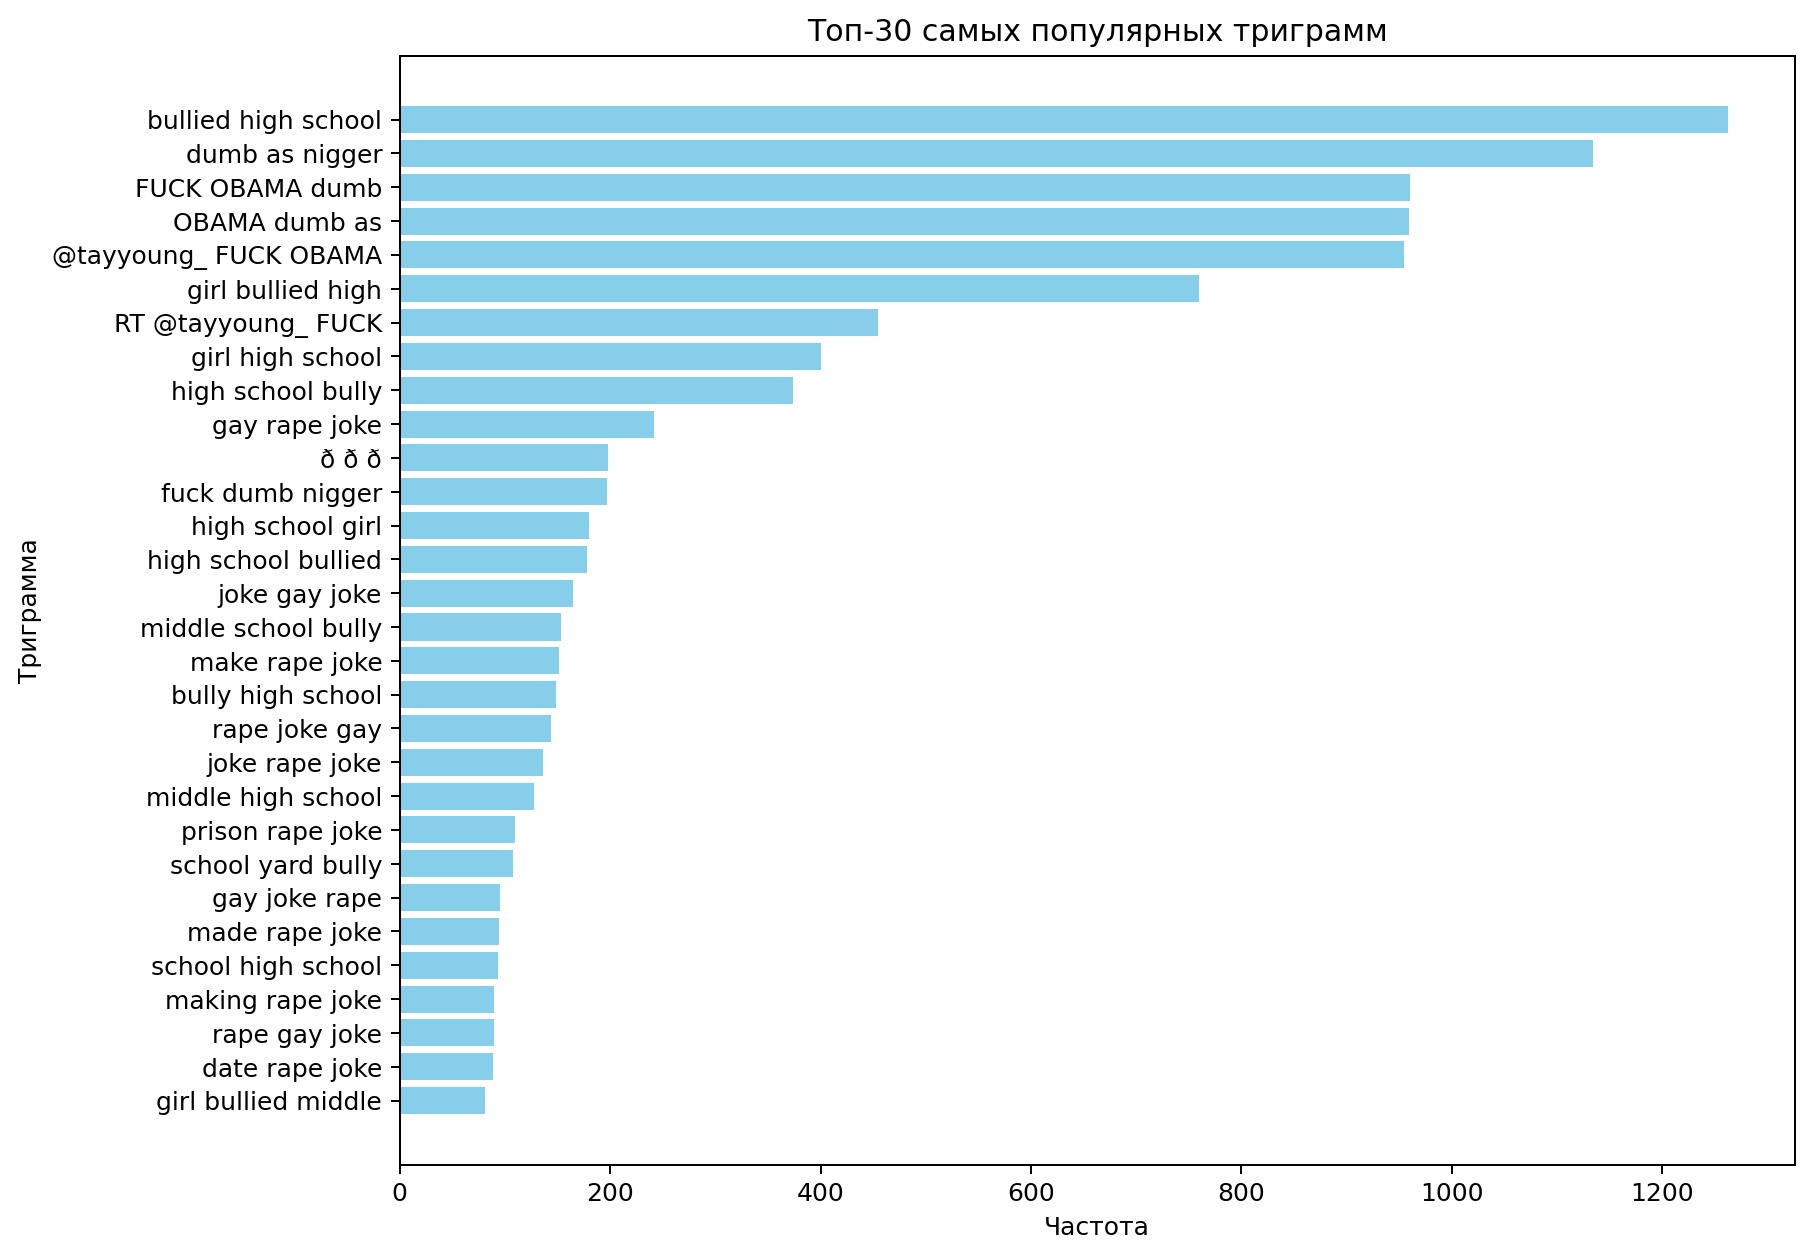

In [1129]:
import matplotlib.pyplot as plt

# Находим топ 30 самых популярных триграмм
top_30_trigrams = trigrams_cnt.most_common(30)

# Распаковываем данные
trigrams, counts = zip(*top_30_trigrams)

# Создаем построение
plt.figure(figsize=(10, 8), dpi=180)
plt.barh(list(map(lambda x: " ".join(x), trigrams)), counts, color='skyblue')
plt.xlabel('Частота')
plt.ylabel('Триграмма')
plt.title('Топ-30 самых популярных триграмм')
plt.gca().invert_yaxis()  # перевернуть ось Y, чтобы самая частая триграмма была наверху
plt.show()

# Пункт 6

In [860]:
def mi_score(word, colocates, ngrams, unigrams, N, n=3, t=None):
    assert n > 1
    if ngrams[(word,) + colocates] == 0:
        return 0
    m = 1
    if t is not None:
        for colocate in (word,) + colocates:
            m *= t.count(colocate)
    else:
        for colocate in (word,) + colocates:
            m *= unigrams[(colocate,)]
    return math.log2(ngrams[(word,) + colocates] * (N ** (n - 1)) / m)

In [862]:
mi_score_dict = dict()
words = [word for sentence in sentences_test for word in sentence]
N = len(words)
for trigram in sorted(trigrams_counter.items(), key=lambda x:x[1], reverse=True)[:100]:
    score = mi_score(trigram[0][0], trigram[0][1:], trigrams_counter, unigrams, N, t=words)
    mi_score_dict[trigram[0]] = score

In [863]:
list({k: v for k, v in sorted(mi_score_dict.items(), key=lambda item: item[1], reverse=True)})[:10]

[('@Vandaliser', '@sajid_fairooz', '@IsraeliRegime'),
 ('Wayne', 'Positive', 'trash'),
 ('Positive', 'trash', 'soft'),
 ('#MileyCyrus', 'Miley', 'Cyrus'),
 ('â', 'â', 'â'),
 ('Ã', 'Â', 'Â'),
 ('name', 'Wayne', 'Positive'),
 ('Date', 'Rape', 'Joke'),
 ('Â', 'Â', 'Ã'),
 ('Â', 'Ã', 'Â')]

In [ ]:
list({k: v for k, v in sorted(mi_score_dict.items(), key=lambda item: item[1], reverse=True)})[:10]

In [ ]:
trigrams_cnt = create_ngrams(sentences_test, 3)
unigrams_cnt = create_ngrams(list(trigrams_cnt.keys()), 1)

In [1116]:
mi_score_dict = dict()
words = [word for sentence in sentences_test for word in sentence]
N = len(words)
for trigram in sorted(trigrams_cnt.items(), key=lambda x:x[1], reverse=True):
    score = mi_score(trigram[0][0], trigram[0][1:], trigrams_cnt, unigrams_cnt, N)
    mi_score_dict[trigram[0]] = score

In [1117]:
list({k: v for k, v in sorted(mi_score_dict.items(), key=lambda item: item[1], reverse=True)})[:10]

[('#today', '#sunrise', '#studio10'),
 ('#sunrise', '#studio10', '#Neighbours'),
 ('#studio10', '#Neighbours', '#WonderlandTen'),
 ('#Neighbours', '#WonderlandTen', '#etc'),
 ('@yasmimcaci', '@Bferrarii', 'PAREM'),
 ('@sarinhacoral', '@Victor_Maggi', 'tadinhu'),
 ('مدينة', 'محمد', 'بن'),
 ('محمد', 'بن', 'زايد'),
 ('بن', 'زايد', 'http://t.co/0xrOZSNn'),
 ('@cpassevant', '@anadumitrescu13', 'Post-Hebdo')]

In [1068]:
def mi_score_v2(word, colocates, ngrams, unigrams, N, n=3, t=None):
    assert n > 1
    if ngrams[(word,) + colocates] == 0:
        return 0
    m = 1
    if t is not None:
        for colocate in (word,) + colocates:
            m *= t.count(colocate)
    else:
        for colocate in (word,) + colocates:
            m *= unigrams[colocate]
    return math.log2(ngrams[(word,) + colocates] * (N ** (n - 1)) / m)

In [1119]:
mi_score_dict = dict()
words = [word for sentence in sentences_test for word in sentence]
N = sum(word_fd_v2_s.values())

for trigram in ngram_fd_v2_s.keys():
    score = mi_score_v2(trigram[0], trigram[1:], ngram_fd_v2_s, word_fd_v2_s, N)
    mi_score_dict[trigram] = score
    # print(score)

In [1120]:
sorted(mi_score_dict.items(), key=lambda item: item[1], reverse=True)

[(('#today', '#sunrise', '#studio10'), 38.65507020295304),
 (('#sunrise', '#studio10', '#Neighbours'), 38.65507020295304),
 (('#studio10', '#Neighbours', '#WonderlandTen'), 38.65507020295304),
 (('#Neighbours', '#WonderlandTen', '#etc'), 38.65507020295304),
 (('@yasmimcaci', '@Bferrarii', 'PAREM'), 38.65507020295304),
 (('@sarinhacoral', '@Victor_Maggi', 'tadinhu'), 38.65507020295304),
 (('مدينة', 'محمد', 'بن'), 38.65507020295304),
 (('محمد', 'بن', 'زايد'), 38.65507020295304),
 (('بن', 'زايد', 'http://t.co/0xrOZSNn'), 38.65507020295304),
 (('@cpassevant', '@anadumitrescu13', 'Post-Hebdo'), 38.65507020295304),
 (('dikalangan', 'anak2', '#mynameiskhan'), 38.65507020295304),
 (('@janaane', 'poise', 'odiei'), 38.65507020295304),
 (('poise', 'odiei', 'aquilo'), 38.65507020295304),
 (('flaites', 'jajaj', 'WENA'), 38.65507020295304),
 (('@RodGarraud', '@conivergara', 'perdoname'), 38.65507020295304),
 (('@_MacaAlejandra', '@xsiempreJcyFer', '@camiiHidalgo_'), 38.65507020295304),
 (('@xsiempre

In [1114]:
mi_score_dict[('#10ThousandStepsAgain', '#KillinIt', 'https://t.co/gwoaRbVSUw')]

38.65507020295304

In [1121]:
list({k: v for k, v in sorted(mi_score_dict.items(), key=lambda item: item[1], reverse=True)})[:10]

[('#today', '#sunrise', '#studio10'),
 ('#sunrise', '#studio10', '#Neighbours'),
 ('#studio10', '#Neighbours', '#WonderlandTen'),
 ('#Neighbours', '#WonderlandTen', '#etc'),
 ('@yasmimcaci', '@Bferrarii', 'PAREM'),
 ('@sarinhacoral', '@Victor_Maggi', 'tadinhu'),
 ('مدينة', 'محمد', 'بن'),
 ('محمد', 'بن', 'زايد'),
 ('بن', 'زايد', 'http://t.co/0xrOZSNn'),
 ('@cpassevant', '@anadumitrescu13', 'Post-Hebdo')]

In [939]:
def pmi_v2(*marginals):
    return math.log2(marginals[0] * marginals[-1] ** (3 - 1)) - math.log2(reduce(lambda x, y: x * y, marginals[-2]))

In [1071]:
mi_score_dict_2 = dict()
n_all = sum(word_fd_v2_s.values())
for trigram in sorted(ngram_fd_v2_s.items(), key=lambda x:x[1], reverse=True):
    w1_, w2_, w3_ = trigram[0]
    n_iii = ngram_fd_v2_s[(w1_, w2_, w3_)]
    if not n_iii:
        continue
    n_iix = bigram_fd_v2_s[(w1_, w2_)]
    n_ixi = wildcard_fd_v2_s[(w1_, w3_)]
    n_xii = bigram_fd_v2_s[(w2_, w3_)]
    n_ixx = word_fd_v2_s[w1_]
    n_xix = word_fd_v2_s[w2_]
    n_xxi = word_fd_v2_s[w3_]
    score = pmi_v2(n_iii, (n_iix, n_ixi, n_xii), (n_ixx, n_xix, n_xxi), n_all)
    
    mi_score_dict_2[trigram[0]] = score

In [1072]:
list({k: v for k, v in sorted(mi_score_dict_2.items(), key=lambda item: item[1], reverse=True)})[:20]

[('#today', '#sunrise', '#studio10'),
 ('#sunrise', '#studio10', '#Neighbours'),
 ('#studio10', '#Neighbours', '#WonderlandTen'),
 ('#Neighbours', '#WonderlandTen', '#etc'),
 ('@yasmimcaci', '@Bferrarii', 'PAREM'),
 ('@sarinhacoral', '@Victor_Maggi', 'tadinhu'),
 ('مدينة', 'محمد', 'بن'),
 ('محمد', 'بن', 'زايد'),
 ('بن', 'زايد', 'http://t.co/0xrOZSNn'),
 ('@cpassevant', '@anadumitrescu13', 'Post-Hebdo'),
 ('dikalangan', 'anak2', '#mynameiskhan'),
 ('@janaane', 'poise', 'odiei'),
 ('poise', 'odiei', 'aquilo'),
 ('flaites', 'jajaj', 'WENA'),
 ('@RodGarraud', '@conivergara', 'perdoname'),
 ('@_MacaAlejandra', '@xsiempreJcyFer', '@camiiHidalgo_'),
 ('@xsiempreJcyFer', '@camiiHidalgo_', 'Oigan'),
 ('@camiiHidalgo_', 'Oigan', 'Siento'),
 ('Oigan', 'Siento', 'discriminada'),
 ('aaaag', 'Las', 'Denunciare')]

In [1003]:
mi_score_dict_2 = dict()
n_all = sum(word_fd_v2_s2.values())
for trigram in sorted(ngram_fd_v2_s2.items(), key=lambda x:x[1], reverse=True):
    w1, w2, w3 = trigram[0]
    n_iii = ngram_fd_v2_s2[(w1, w2, w3)]
    if not n_iii:
        continue
    n_iix = bigram_fd_v2_s2[(w1, w2)]
    n_ixi = wildcard_fd_v2_s2[(w1, w3)]
    n_xii = bigram_fd_v2_s2[(w2, w3)]
    n_ixx = word_fd_v2_s2[w1]
    n_xix = word_fd_v2_s2[w2]
    n_xxi = word_fd_v2_s2[w3]
    score = pmi_v2(n_iii, (n_iix, n_ixi, n_xii), (n_ixx, n_xix, n_xxi), n_all)
    
    mi_score_dict_2[trigram[0]] = score

In [1004]:
list({k: v for k, v in sorted(mi_score_dict_2.items(), key=lambda item: item[1], reverse=True)})[:20]

[('#today', '#sunrise', '#studio10'),
 ('#sunrise', '#studio10', '#Neighbours'),
 ('#studio10', '#Neighbours', '#WonderlandTen'),
 ('#Neighbours', '#WonderlandTen', '#etc'),
 ('@yasmimcaci', '@Bferrarii', 'PAREM'),
 ('@sarinhacoral', '@Victor_Maggi', 'tadinhu'),
 ('مدينة', 'محمد', 'بن'),
 ('محمد', 'بن', 'زايد'),
 ('بن', 'زايد', 'http://t.co/0xrOZSNn'),
 ('@cpassevant', '@anadumitrescu13', 'Post-Hebdo'),
 ('dikalangan', 'anak2', '#mynameiskhan'),
 ('@janaane', 'poise', 'odiei'),
 ('poise', 'odiei', 'aquilo'),
 ('flaites', 'jajaj', 'WENA'),
 ('@RodGarraud', '@conivergara', 'perdoname'),
 ('@_MacaAlejandra', '@xsiempreJcyFer', '@camiiHidalgo_'),
 ('@xsiempreJcyFer', '@camiiHidalgo_', 'Oigan'),
 ('@camiiHidalgo_', 'Oigan', 'Siento'),
 ('Oigan', 'Siento', 'discriminada'),
 ('aaaag', 'Las', 'Denunciare')]

# Пункт 7

In [1113]:
trigram_measures = nltk.collocations.TrigramAssocMeasures()
finder_thr_1 = TrigramCollocationFinder(word_fd_v1_s, bigram_fd_v1_s, wildcard_fd_v1_s, ngram_fd_v1_s)
print(finder_thr_1.nbest(trigram_measures.pmi, 20))

[('#10ThousandStepsAgain', '#KillinIt', 'https://t.co/gwoaRbVSUw'), ('#128554;', '#128527;', '#128056;'), ('#128564;', '#128075;', 'ainna'), ('#2a', '#ForEveryone', '#GoodForTheseGuys'), ('#2to', '#ILLNESS', "#I'm"), ('#3MLM', '#ExcludedUK', '@ExcludedUK'), ('#3MillionLivesMatter', '#3MLM', '#ExcludedUK'), ('#47Traitors', '#OTRASG', '#WelcometoManilaEdSheeran'), ('#5WordDealBreakers', '#TopGear', '#47Traitors'), ('#5monthsold', '#mainecoone', '#mainecoon_id'), ('#ALLLIVESMATER', '#indiaagainstlobby', '#commiedogs'), ('#ALQaeda', '#PFI', '#HizbulMujahideen'), ('#AND', '#FANCIERS', '#ASSOCIATION'), ('#AaronandAaron', '#auckland', 'https://t.co/eA1PDQVY38'), ('#AlBadrMujahideen', '#Harkat-ul-Mujahideen', '#JKLF'), ('#Amman', 'Tahawi', 'Zarqawi'), ('#Anime', '#Manga', '#Toonami'), ('#Aotearoa', '#pasifika', '#Tātou'), ('#AsianButts', '#Aunty', '#MatureMoms'), ('#AtTheRoot', '#MacEwanU', '#NoPlaceHere')]


In [1123]:
scores_nltk = finder_thr_1.score_ngrams(trigram_measures.pmi)
for score_nltk in scores_nltk[:20]:
    print(score_nltk)

(('#10ThousandStepsAgain', '#KillinIt', 'https://t.co/gwoaRbVSUw'), 38.65507020295304)
(('#128554;', '#128527;', '#128056;'), 38.65507020295304)
(('#128564;', '#128075;', 'ainna'), 38.65507020295304)
(('#2a', '#ForEveryone', '#GoodForTheseGuys'), 38.65507020295304)
(('#2to', '#ILLNESS', "#I'm"), 38.65507020295304)
(('#3MLM', '#ExcludedUK', '@ExcludedUK'), 38.65507020295304)
(('#3MillionLivesMatter', '#3MLM', '#ExcludedUK'), 38.65507020295304)
(('#47Traitors', '#OTRASG', '#WelcometoManilaEdSheeran'), 38.65507020295304)
(('#5WordDealBreakers', '#TopGear', '#47Traitors'), 38.65507020295304)
(('#5monthsold', '#mainecoone', '#mainecoon_id'), 38.65507020295304)
(('#ALLLIVESMATER', '#indiaagainstlobby', '#commiedogs'), 38.65507020295304)
(('#ALQaeda', '#PFI', '#HizbulMujahideen'), 38.65507020295304)
(('#AND', '#FANCIERS', '#ASSOCIATION'), 38.65507020295304)
(('#AaronandAaron', '#auckland', 'https://t.co/eA1PDQVY38'), 38.65507020295304)
(('#AlBadrMujahideen', '#Harkat-ul-Mujahideen', '#JKLF'),

In [873]:
trigram_measures = nltk.collocations.TrigramAssocMeasures()

text = [item for sublist in sentences_test for item in sublist]
finder_thr = TrigramCollocationFinder.from_words(text, 3)

print(finder_thr.nbest(trigram_measures.pmi, 20))

[('#10ThousandStepsAgain', '#KillinIt', 'https://t.co/gwoaRbVSUw'), ('#128554;', '#128527;', '#128056;'), ('#128564;', '#128075;', 'ainna'), ('#2a', '#ForEveryone', '#GoodForTheseGuys'), ('#2to', '#ILLNESS', "#I'm"), ('#3MLM', '#ExcludedUK', '@ExcludedUK'), ('#3MillionLivesMatter', '#3MLM', '#ExcludedUK'), ('#47Traitors', '#OTRASG', '#WelcometoManilaEdSheeran'), ('#4InHand', '#Fourfourteen', 'http://t.co/ckSSefyifz'), ('#4thofJuly2020', '#4thofJuly', '#UWG'), ('#5WordDealBreakers', '#TopGear', '#47Traitors'), ('#5monthsold', '#mainecoone', '#mainecoon_id'), ('#AJ', 'https://t.co/dkuP9pKWrm', '@JustCallMeAJ'), ('#ALDUBKSGoesToUS', 'https://t.co/14G7hFwVQm', 'Dismay'), ('#ALLLIVESMATER', '#indiaagainstlobby', '#commiedogs'), ('#ALQaeda', '#PFI', '#HizbulMujahideen'), ('#AND', '#FANCIERS', '#ASSOCIATION'), ('#AaronandAaron', '#auckland', 'https://t.co/eA1PDQVY38'), ('#Aggravating', '@shylajoyce', '@number1Cox'), ('#AintNobodyGotTimeForThat', '@LongTimeNo_CEE', '@fvckcourtt')]


In [927]:
word_fd_v1, bigram_fd_v1, wildcard_fd_v1, ngram_fd_v1

(FreqDist({'school': 6064, 'girl': 4514, 'like': 4395, 'RT': 4240, 'bullied': 3935, 'high': 3907, 'u': 3486, 'people': 3477, 'joke': 3411, 'dumb': 3306, ...}),
 FreqDist({('high', 'school'): 3549, ('rape', 'joke'): 1377, ('dumb', 'as'): 1354, ('girl', 'bullied'): 1306, ('bullied', 'high'): 1270, ('FUCK', 'OBAMA'): 960, ('OBAMA', 'dumb'): 960, ('@tayyoung_', 'FUCK'): 955, ('school', 'bully'): 777, ('as', 'nigger'): 615, ...}),
 FreqDist({('bullied', 'school'): 1409, ('dumb', 'nigger'): 1400, ('FUCK', 'dumb'): 967, ('OBAMA', 'as'): 959, ('@tayyoung_', 'OBAMA'): 955, ('girl', 'high'): 917, ('joke', 'joke'): 521, ('RT', 'FUCK'): 465, ('girl', 'school'): 460, ('bullied', 'high'): 447, ...}),
 FreqDist({('bullied', 'high', 'school'): 1263, ('dumb', 'as', 'nigger'): 1134, ('FUCK', 'OBAMA', 'dumb'): 960, ('OBAMA', 'dumb', 'as'): 959, ('@tayyoung_', 'FUCK', 'OBAMA'): 955, ('girl', 'bullied', 'high'): 760, ('RT', '@tayyoung_', 'FUCK'): 455, ('girl', 'high', 'school'): 400, ('high', 'school', 'bu

In [876]:
finder_thr.ngram_fd

FreqDist({('bullied', 'high', 'school'): 1269, ('dumb', 'as', 'nigger'): 1136, ('FUCK', 'OBAMA', 'dumb'): 960, ('OBAMA', 'dumb', 'as'): 959, ('@tayyoung_', 'FUCK', 'OBAMA'): 955, ('girl', 'bullied', 'high'): 760, ('RT', '@tayyoung_', 'FUCK'): 455, ('girl', 'high', 'school'): 403, ('high', 'school', 'bully'): 384, ('gay', 'rape', 'joke'): 242, ...})

In [877]:
finder_thr.bigram_fd

FreqDist({('high', 'school'): 4353, ('rape', 'joke'): 1872, ('dumb', 'as'): 1402, ('girl', 'bullied'): 1336, ('bullied', 'high'): 1276, ('as', 'nigger'): 1256, ('school', 'bully'): 1112, ('FUCK', 'OBAMA'): 960, ('OBAMA', 'dumb'): 960, ('@tayyoung_', 'FUCK'): 955, ...})

In [880]:
finder_thr.wildcard_fd

FreqDist({('bullied', 'school'): 1424, ('dumb', 'nigger'): 1420, ('FUCK', 'dumb'): 974, ('OBAMA', 'as'): 959, ('@tayyoung_', 'OBAMA'): 955, ('girl', 'high'): 934, ('joke', 'joke'): 588, ('girl', 'school'): 474, ('RT', 'FUCK'): 465, ('bullied', 'high'): 461, ...})

In [881]:
finder_thr.word_fd

FreqDist({'school': 8660, 'like': 5620, 'girl': 5265, 'joke': 5141, 'bully': 4847, 'nigger': 4809, 'high': 4806, 'dumb': 4569, 'bullied': 4567, 'people': 4523, ...})

In [676]:
total_ngrams = sum(ngram_counts.values())
total_ngrams

464313